In [2]:
%matplotlib widget
import numpy as np
np.random.seed(69420)
import seaborn as sns
import pandas as pd
from scipy import spatial, stats
from functools import reduce
import matplotlib.pyplot as plt
import nrrd
import pytest
import ipytest
ipytest.autoconfig(raise_on_error=True)
import raster_geometry as rg

In [3]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1-point2)

In [4]:
test_random_points = stats.uniform.rvs(0, 100, (100,3))
print(test_random_points)
# N = random_points.shape[0]


[[5.31092242e+01 3.56763974e+01 5.13116143e+01]
 [3.25304679e+01 4.57249669e+01 1.40732654e+00]
 [4.59841021e+01 3.54952976e+01 9.83034430e+01]
 [4.23662559e+01 6.03271985e+01 3.26266145e+01]
 [2.27160592e+01 3.91371938e+01 8.97519939e+01]
 [6.18954164e+01 4.62790399e+01 9.05805007e+01]
 [1.99007522e+00 4.81828623e+01 4.83698230e+01]
 [2.62086181e+00 4.31961456e+01 4.79422250e+01]
 [1.27656766e+01 8.50994756e+01 3.01388534e+01]
 [5.20958581e+01 3.02612945e+01 6.19471513e+01]
 [9.72647864e+00 8.94853896e+01 4.08314831e+01]
 [9.44245486e+01 3.06435243e+01 2.15346129e+01]
 [7.43635375e+01 9.63100863e+01 5.95385416e+01]
 [2.64369528e+01 9.10006253e+01 3.51407408e+01]
 [4.96678444e+01 3.92272325e+01 2.37518829e+01]
 [4.44099775e+01 9.32534104e+01 9.96492671e+01]
 [9.68019775e+01 5.60535806e+01 9.29470211e+01]
 [2.67746809e+01 7.64448747e+01 3.57479539e+01]
 [5.07426556e+01 2.11085724e+01 8.00584715e+01]
 [7.80833695e+01 7.70640729e+01 8.35704827e+01]
 [9.08087345e+01 3.14182266e+01 6.149789

In [5]:
# Test distance function
print(euclidean_distance(np.array((10,10,10)),np.array((0,0,0))))

17.320508075688775


In [6]:
def set_aspect_ratio_equal(ax) -> None:
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    ax.set_box_aspect((xlim[1]-xlim[0], ylim[1]-ylim[0], zlim[1]-zlim[0]))

In [56]:
def calculate_weight(shape, radius, midpoint):
    ### Calculate proportion of sphere within study volume
    # check that radius is smaller than half of the smallest dimension
    assert radius < min(shape) / 2

    # determine center of study volume
    center = (shape[0]//2, shape[1]//2, shape[2]//2)

    # draw target sphere in numpy space at specified midpoint and reference sphere at middle of volume
    target = rg.nd_superellipsoid(shape, radius, position=midpoint, rel_sizes=False, rel_position=False)
    reference = rg.nd_superellipsoid(shape, radius, position=center, rel_sizes=False, rel_position=False)

    # calculate proportion of volumes to determine weight
    return target.astype(np.int_).sum() / reference.astype(np.int_).sum()

In [57]:
calculate_weight((100,100,100), 7, (2,2,2))

0.41508104298801973

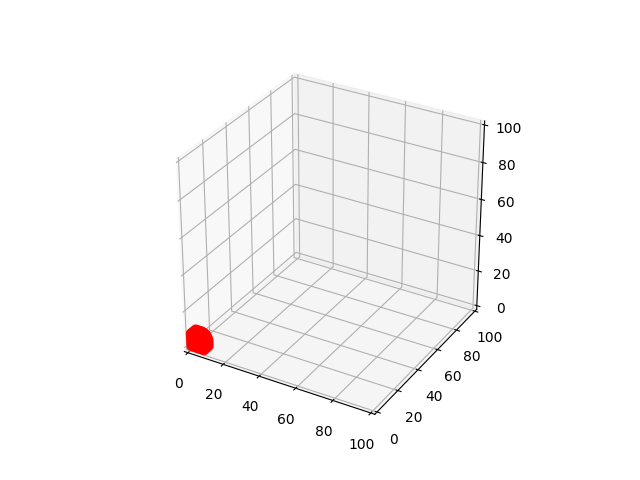

In [54]:
# Test sphere drawing
def draw_sphere(shape, radius, center) -> np.ndarray:
    sphere = rg.nd_superellipsoid(shape, radius, position=center, rel_sizes=False, rel_position=False)
    return sphere.astype(np.int_)

container_shape = (100, 100, 100)
radius = 7
center = (2, 2, 2)

# print(calculate_weight(container_shape, radius, center))
test_sphere = draw_sphere(container_shape, radius, center)

from mpl_toolkits.mplot3d import Axes3D
z,x,y = test_sphere.nonzero()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
set_aspect_ratio_equal(ax)
ax.axes.set_xlim3d(left=0, right=container_shape[1]) 
ax.axes.set_ylim3d(bottom=0, top=container_shape[2]) 
ax.axes.set_zlim3d(bottom=0, top=container_shape[0]) 
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.show()

In [8]:
x_min = 0; x_max = 100
y_min = 0; y_max = 100
z_min = 0; z_max = 100
total_volume = (x_max - x_min)*(y_max - y_min)*(z_max - z_min)

In [9]:
# Currently using x_max-x_min as maximum radius, by convention it should be sqrt(x_max-x_min/2)
radii = np.linspace(0,x_max-x_min,50).reshape(50,1)

In [10]:
test_tree = spatial.cKDTree(test_random_points)
idx_in = test_tree.query_ball_point((50,50,50),20)

idx_out = np.ones(len(test_random_points), bool)
idx_out[idx_in] = 0

pts_inside_radius = test_random_points[idx_in]
pts_outside_radius = test_random_points[idx_out]

print(len(test_random_points), len(pts_inside_radius), len(pts_outside_radius))

100 4 96


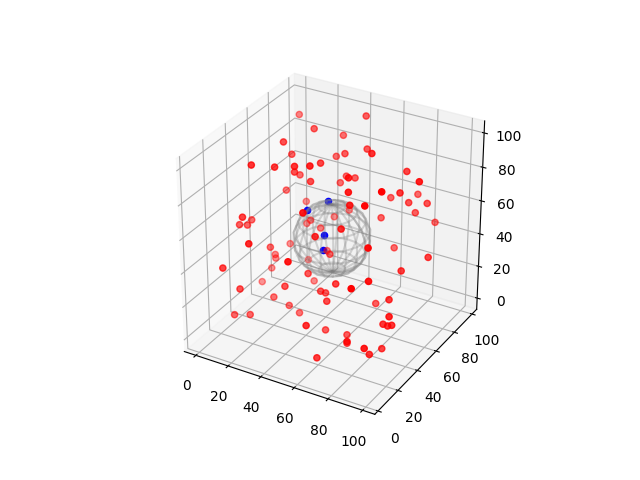

In [11]:
ix, ox = pts_inside_radius[:, 0], pts_outside_radius[:, 0]
iy, oy = pts_inside_radius[:, 1], pts_outside_radius[:, 1]
iz, oz = pts_inside_radius[:, 2], pts_outside_radius[:, 2]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
set_aspect_ratio_equal(ax)
ax.scatter(ix,iy,iz, color="b",marker="o", depthshade=0)
ax.scatter(ox,oy,oz,color="r",marker="o", depthshade=1)


scale = 20
# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
cx = scale*np.cos(u)*np.sin(v)+50
cy = scale*np.sin(u)*np.sin(v)+50
cz = scale*np.cos(v)+50
ax.plot_wireframe(cx, cy, cz, color="gray", alpha=0.3)


In [12]:
# For this rectangular test case, volume_mask is just an array of ones
volume = 100*100*100
volume_mask = np.ones((100, 100, 100))

print(volume)
print(volume_mask.sum())

1000000
1000000.0


Ripley's K Estimators

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BK%7D%28r%29%3D%20%5Cfrac%7BV%7D%7BN%28N-1%29%7D%20%5Csum_i%5EN%20%5Csum_%7Bj%20%5Cneq%20i%7D%5EN%20%20%5Cfrac%7BI%28d_%7Bi%2Cj%7D%3Cr%29%7D%7B%5Comega_%7Bi%2Cj%7D%7D%20%20%20%20%20&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BL%7D%28r%29%3D%20%20%20%5Csqrt%5B3%5D%7B%5Cfrac%7B3%20%20%5Cwidehat%7BK%7D%28r%29%7D%7B4%5Cpi%7D%7D&bc=White&fc=Black&im=jpg&fs=18&ff=arev&edit=0)

![equation](http://www.sciweavers.org/tex2img.php?eq=%5Cwidehat%7BH%7D%28r%29%3D%5Cwidehat%7BL%7D%28r%29-r&bc=White&fc=Black&im=jpg&fs=12&ff=arev&edit=0)

In [13]:
def ripley(points: np.ndarray, radii: list, volume_shape: tuple, boundary_correction: bool = True) -> tuple:
    """
    Calculate RipleyK spatial statistic on 3D point cloud

    args:
        points (numpy.ndarray): shape (N, 3), where N is the number of points
        radii (list[int]): list of radii to compute
        volume_shape (tuple[int]): shape of the entire study volume. Example: (100,100,100)

    """
    ### Function starts with input checks

    # Check if points is a list or numpy array
    if not isinstance(points, (list, np.ndarray)):
        e = f"Expected {np.ndarray}, received {type(points)}"
        raise ValueError(e)

    # Convert points to numpy array if it is a list
    if not isinstance(points, np.ndarray):
        points = np.array(points)

    # Check if points array has two dimensions
    if len(points.shape) != 2:
        e = f"Expected points array to have 2 dimensions, but got array with shape {points.shape}"
        raise ValueError(e)

    # Check if the points array second dimension length is 3 (x, y, z)
    if points.shape[1] != 3:
        e = f"Expected points array to have shape (None, 3), but got array with shape {points.shape}"
        raise ValueError(e)

    # Check if the points array has at least 3 points
    if points.shape[0] < 3:
        e = f"Expected points array to have at least 3 points"
        raise ValueError(e)

    # Check if radii is list-like or number-like
    if not isinstance(radii, (np.ndarray, list, int, float)):
        e = f"Expected {(np.ndarray, list, int, float)}, received {type(radii)}"
        raise ValueError(e)

    # if only one radius given as int, convert to list
    if not isinstance(radii, (np.ndarray, list)):
        radii = [radii]

    ### Compute Ripley's K Statistic 
    
    results = {"K": [], "L": [], "H": []}
    tree = spatial.cKDTree(points)
    N = points.shape[0]
    study_volume = reduce(lambda x, y: x * y, volume_shape)

    # Loop through each radius
    for radius in radii:
        # For each radius, loop through each point and count points
        # within the radius
        nb_count = 0
        for x, y, z in points:
            # TODO: doublecheck that the z,x,y ordering is correct and properly aligns with mask
            if boundary_correction:
                weight = calculate_weight(volume_shape, radius, (z, x, y))
            else:
                weight = 1.0
            # query_ball_point() includes the index of the current point as well
            # so 1 is subtracted from the count
            nb_count += (len(tree.query_ball_point([x, y, z], radius)) - 1) / weight

        # calculating 3D Ripley's functions (K, L, H)
        K = nb_count * study_volume / (N * (N - 1))
        L = ((3. / 4) * (K / np.pi)) ** (1. / 3)
        H = L - radius

        # Verify K/L values positive
        if K < 0 or L < 0:
            raise ValueError(f"K/L values should not be negative. nb_count: {nb_count}, volume: {volume}, N: {N}")

        results["K"].append(K)
        results["L"].append(L)
        results["H"].append(H)
    
    return results["K"], results["L"], results["H"]




SyntaxError: invalid syntax (1676989433.py, line 51)

In [22]:
a = volume_mask.shape




1000000

### Complete Spatial Randomness (CSR) Representations

In [ ]:
CSR_data = []
radii=np.arange(0, 50)
for i in range(100):
    CSR_points = stats.uniform.rvs(0, 100, (100,3))
    K, L, H = ripley(CSR_points, radii, volume)
    CSR_data += zip(radii, K, L, H, ["CSR"]*len(radii), [i]*len(radii))
rstats = pd.DataFrame(CSR_data, columns=["Radius (r)", "K(r)", "L(r)", "H(r)", "Type", "Line"])
rstats


In [ ]:
f, axes = plt.subplots(2, 3,)

## Top Row
# K
sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[0, 0], hue="Line")
# L
sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[0, 1], hue="Line")
axes[0, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[0, 2], hue="Line")
axes[0, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

## Bottom Row
# K
sns.lineplot(data=rstats, x="Radius (r)", y="K(r)", ax=axes[1, 0], alpha=0, errorbar=("pi", 95))
# L
sns.lineplot(data=rstats, x="Radius (r)", y="L(r)", ax=axes[1, 1], alpha=0, errorbar=("pi", 95))
axes[1, 1].plot([0, 50], [0, 50], linewidth=1, linestyle="dotted", color="#aaa") # Expected line
# H
sns.lineplot(data=rstats, x="Radius (r)", y="H(r)", ax=axes[1, 2], alpha=0, errorbar=("pi", 95))
axes[1, 2].plot([0, 50], [0, 0], linewidth=1, linestyle="dotted", color="#aaa") # Expected line

plt.show()



In [ ]:
%%ipytest

# Tests
def test_valid_input():
    valid_points = [
        np.array([[38.4002419, 38.62931512, 41.6131775], [38, 38, 41], [1, 6, 8]]),
        np.array([[38, 38, 41], [1, 2, 3], [20, 20, 20]]),
        [[38.4002419, 38.62931512, 41.6131775], [3.4002419, 8.62931512, 1.6131775], [8.4002419, 3.62931512, 4.6131775]],
        [[38, 38, 41], [1, 2, 3], [4, 5, 6]],
    ]
    for p in valid_points:
        ripley(p, radii=1, volume=100*100*100)

def test_invalid_input():
    invalid_points = [
        np.array([[38.4002419, 38.62931512, 41.6131775]]),
        np.array([[38, 38, 41], [1, 2, 3]]),
        [[38.4002419, 38.62931512, 41.6131775]],
        [[38, 38, 41], [1, 2, 3]],
        "38.4002419, 38.62931512, 41.6131775",
        np.array([38.4002419, 38.62931512, 41.6131775]),
        np.array([[[38.4002419, 38.62931512, 41.6131775]]]),
        np.array([[38.4002419, 38.62931512]]),
        5,
        7.8,
        [6],
    ]
    for p in invalid_points:
        with pytest.raises(ValueError):
            ripley(p, radii=1, volume=100*100*100)


In [ ]:
mask_path = "D:\\Datasets\\Bone_Mets\\masks\\FV10__20190620_111343.seg.nrrd"

# Load mask from NRRD
mask, header = nrrd.read(mask_path)
mask = mask.T
mask = mask[:mask.shape[0]//3, :, :]

print(mask.shape)
print(mask.dtype)



In [ ]:
fig = plt.figure()
plt.imshow(mask[40])

In [ ]:
print(np.unique(mask))
print(mask.sum())

In [ ]:
def calculate_ripley(radii, sample_size, d1=None, d2=None, d3=None, sample_shape='circle', boundary_correct=False, CSR_Normalise=False):
    results = []
    tree, dimensions = make_tree(d1=d1, d2=d2, d3=d3)
    if type(radii) is not list:
        radii = [radii]
    for radius in radii:
        
        score_vol = (4/3) * np.pi * radius**3
        
        if sample_shape=='circle':
            bound_size = (4/3) * np.pi * sample_size ** 3
        elif sample_shape=='rectangle':
            bound_size = sample_size[0]*sample_size[1]*sample_size[2]
        counts = 0
        for x, y, z in zip(d1, d2, d3):
            if boundary_correct:
                vol = calculate_overlap([x,y,z], sample_size, radius, sample_shape, dimensions)
                boundary_correction = vol/score_vol
                counts += (len(tree.query_ball_point([x,y,z], radius))-1)/boundary_correction
            else:
                counts += len(tree.query_ball_point([x,y,z], radius))-1
                    
        if CSR_Normalise:
            results.append((bound_size*counts/len(d1)**2) - score_vol)
        else:
            results.append(bound_size*counts/len(d1)**2)
    if len(results)==1:
        return results[0]
    else:
        return results

In [ ]:
# def draw_sphere(arr: np.ndarray, radius: int, coords: list):
#     x_min, x_max = max(coords[0] - radius, 0), min(coords[0] + radius, arr.shape[0])
#     y_min, y_max = max(coords[1] - radius, 0), min(coords[1] + radius, arr.shape[1])
#     z_min, z_max = max(coords[2] - radius, 0), min(coords[2] + radius, arr.shape[2])
#     arr_overlap = [(max(coords[i] - radius, 0), min(coords[i] + radius, arr.shape[i])) for i in range(len(coords))]

#     kernel_size = (2 * radius) + 1
#     sphere_kernel = rg.sphere(kernel_size, r).astype(np.int_)

#     low_indices = [coords[i] - radius if coords[i] - radius > 0 else 0 for i in range(len(coords))]
#     high_indices =

#     idx_low = coords[0] - radius if coords[0] - radius > 0 else 0
#     idx_high = coords[0] + radius if coords[0] + radius >= arr.shape[0] else arr.shape[0]

#     if idx_low < 0:
#         sphere_kernel = sphere_kernel[abs(idx_low):, :, :]
#     if idx_high >= arr.shape[0]:
#         deltaX = arr.shape[0] - idx_high
#         assert deltaX < 0
#         sphere_kernel = sphere_kernel[:deltaX, :, :]


#     return arr[x_min: x_max + 1,
#                y_min: y_max + 1,
#                z_min: z_max + 1]
    
    
# test_vol = np.zeros((10,10,10))
# a = draw_sphere(test_vol, 1, (0,0,0))   
# print(a.shape)
# print(a)